In [1]:
%matplotlib inline

In [2]:
from functools import cache

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
import requests
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt
from scipy import stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
sns.set_theme()
az.style.use("arviz-docgrid")

In [4]:
API = "http://ergast.com/api/f1"

In [5]:
STATUS_FINISHED = ["Finished", "+1 Lap", "+2 Laps"]

@cache
def get_season_schedule(year):
    URL = f"{API}/{year}/results.json?limit=400"

    response = requests.get(URL)
    response.raise_for_status()
    return response.json()


@cache
def race_results(year, race):
    URL = f"{API}/{year}/{race}/results.json"

    response = requests.get(URL)
    response.raise_for_status()

    return response.json()


def to_dataframe(json_data):
    data = {}
    for race in json_data:
        for result in race["Results"]:
            data.setdefault("circuit", []).append(race["Circuit"]["circuitId"])
            data.setdefault("driver", []).append(result["Driver"]["code"])
            data.setdefault("round", []).append(race["round"])
            data.setdefault("constructor", []).append(
                result["Constructor"]["constructorId"]
            )

            data.setdefault("grid", []).append(result["grid"])
            data.setdefault("position", []).append(result["position"])
            data.setdefault("points", []).append(result["points"])
            data.setdefault("fastest_lap", []).append(
                result.get("FastestLap", {}).get("rank")
            )
            data.setdefault("status", []).append(result["status"])

    return (
        pd.DataFrame(data)
        .astype(
            {
                "circuit": "category",
                "driver": "category",
                "round": "int",
                "constructor": "category",
                "status": "category",
                "grid": "Int64",
                "position": "Int64",
                "points": "float32",
                "fastest_lap": "Int64",
            }
        )
        .set_index(["circuit", "driver"])
    )


def score_constructor(x):
    finished = x["status"].isin(STATUS_FINISHED)
    match finished.sum():
        case 2:
            finish_bonus = 5
        case 1:
            finish_bonus = 2
        case _:
            finish_bonus = 0

    return x["points"].sum() + x[finished]["positions_gained"].sum() + finish_bonus


def score_driver(x):
    return pd.Series(
        x["points"]
        + x["has_pole"] * 10
        + x["positions_gained"] * 2
        + x["beat_teammate_quali"] * 5
        + x["beat_teammate_race"] * 5,
        dtype=float,
    ).where(x["status"].isin(STATUS_FINISHED), 0)

In [6]:
season = get_season_schedule(2023)

In [7]:
races = season["MRData"]["RaceTable"]["Races"]

In [8]:
df = to_dataframe(races)
df = (
    df.assign(
        # Grid value of 0 indicates pit lane start; here we set that to 99
        # to simplify the check for who won out in qualifying.
        grid=lambda x: x["grid"].where(x["grid"] != 0, 20)
    )
    .assign(
        # Positions gained compared to the starting grid position; scoring doesn't
        # care about positions lost, so we set anything below 0 to 0.
        positions_gained=lambda x: np.maximum(x["grid"] - x["position"], 0),
        # Whether the driver won pole position
        has_pole=lambda x: x["grid"] == 1,
        # Whether the driver beat their teammate in qualifying
        beat_teammate_quali=lambda x: x.groupby(
            # Each group is per race, per constructor, so only 2 rows - one for each driver.
            ["circuit", "constructor"],
            group_keys=False,
        ).apply(
            # Smaller grid pos. = better; the grid position is compared
            # to the reversed grid array in the group (essentially
            # we create a cartesian product of the grid pos.)
            lambda g: g["grid"]
            < g["grid"].iloc[::-1].values
        ),
        # Same as the previous column, but for finishing position in the race.
        beat_teammate_race=lambda x: x.groupby(
            ["circuit", "constructor"], group_keys=False
        ).apply(
            lambda g: (g["position"] < g["position"].iloc[::-1].values)
            & g["status"].isin(STATUS_FINISHED)
        ),
        has_fastest_lap=lambda x: x["fastest_lap"] == 1,
    )
    .assign(
        driver_points=score_driver,
        # Constructor points need to be joined back in on the grouping columns, in order to
        # fill in the missing spots with duplicate values - since we have 20 drivers, but 10 constructors,
        # the group has fewer rows and needs to be broadcast per group on the index.
        constructor_points=lambda x: x.join(
            x.groupby(["circuit", "constructor"])
            .apply(score_constructor)
            .rename("constructor_points"),
            on=["circuit", "constructor"],
        )["constructor_points"],
    )
)

[Text(0, 0.5, '')]

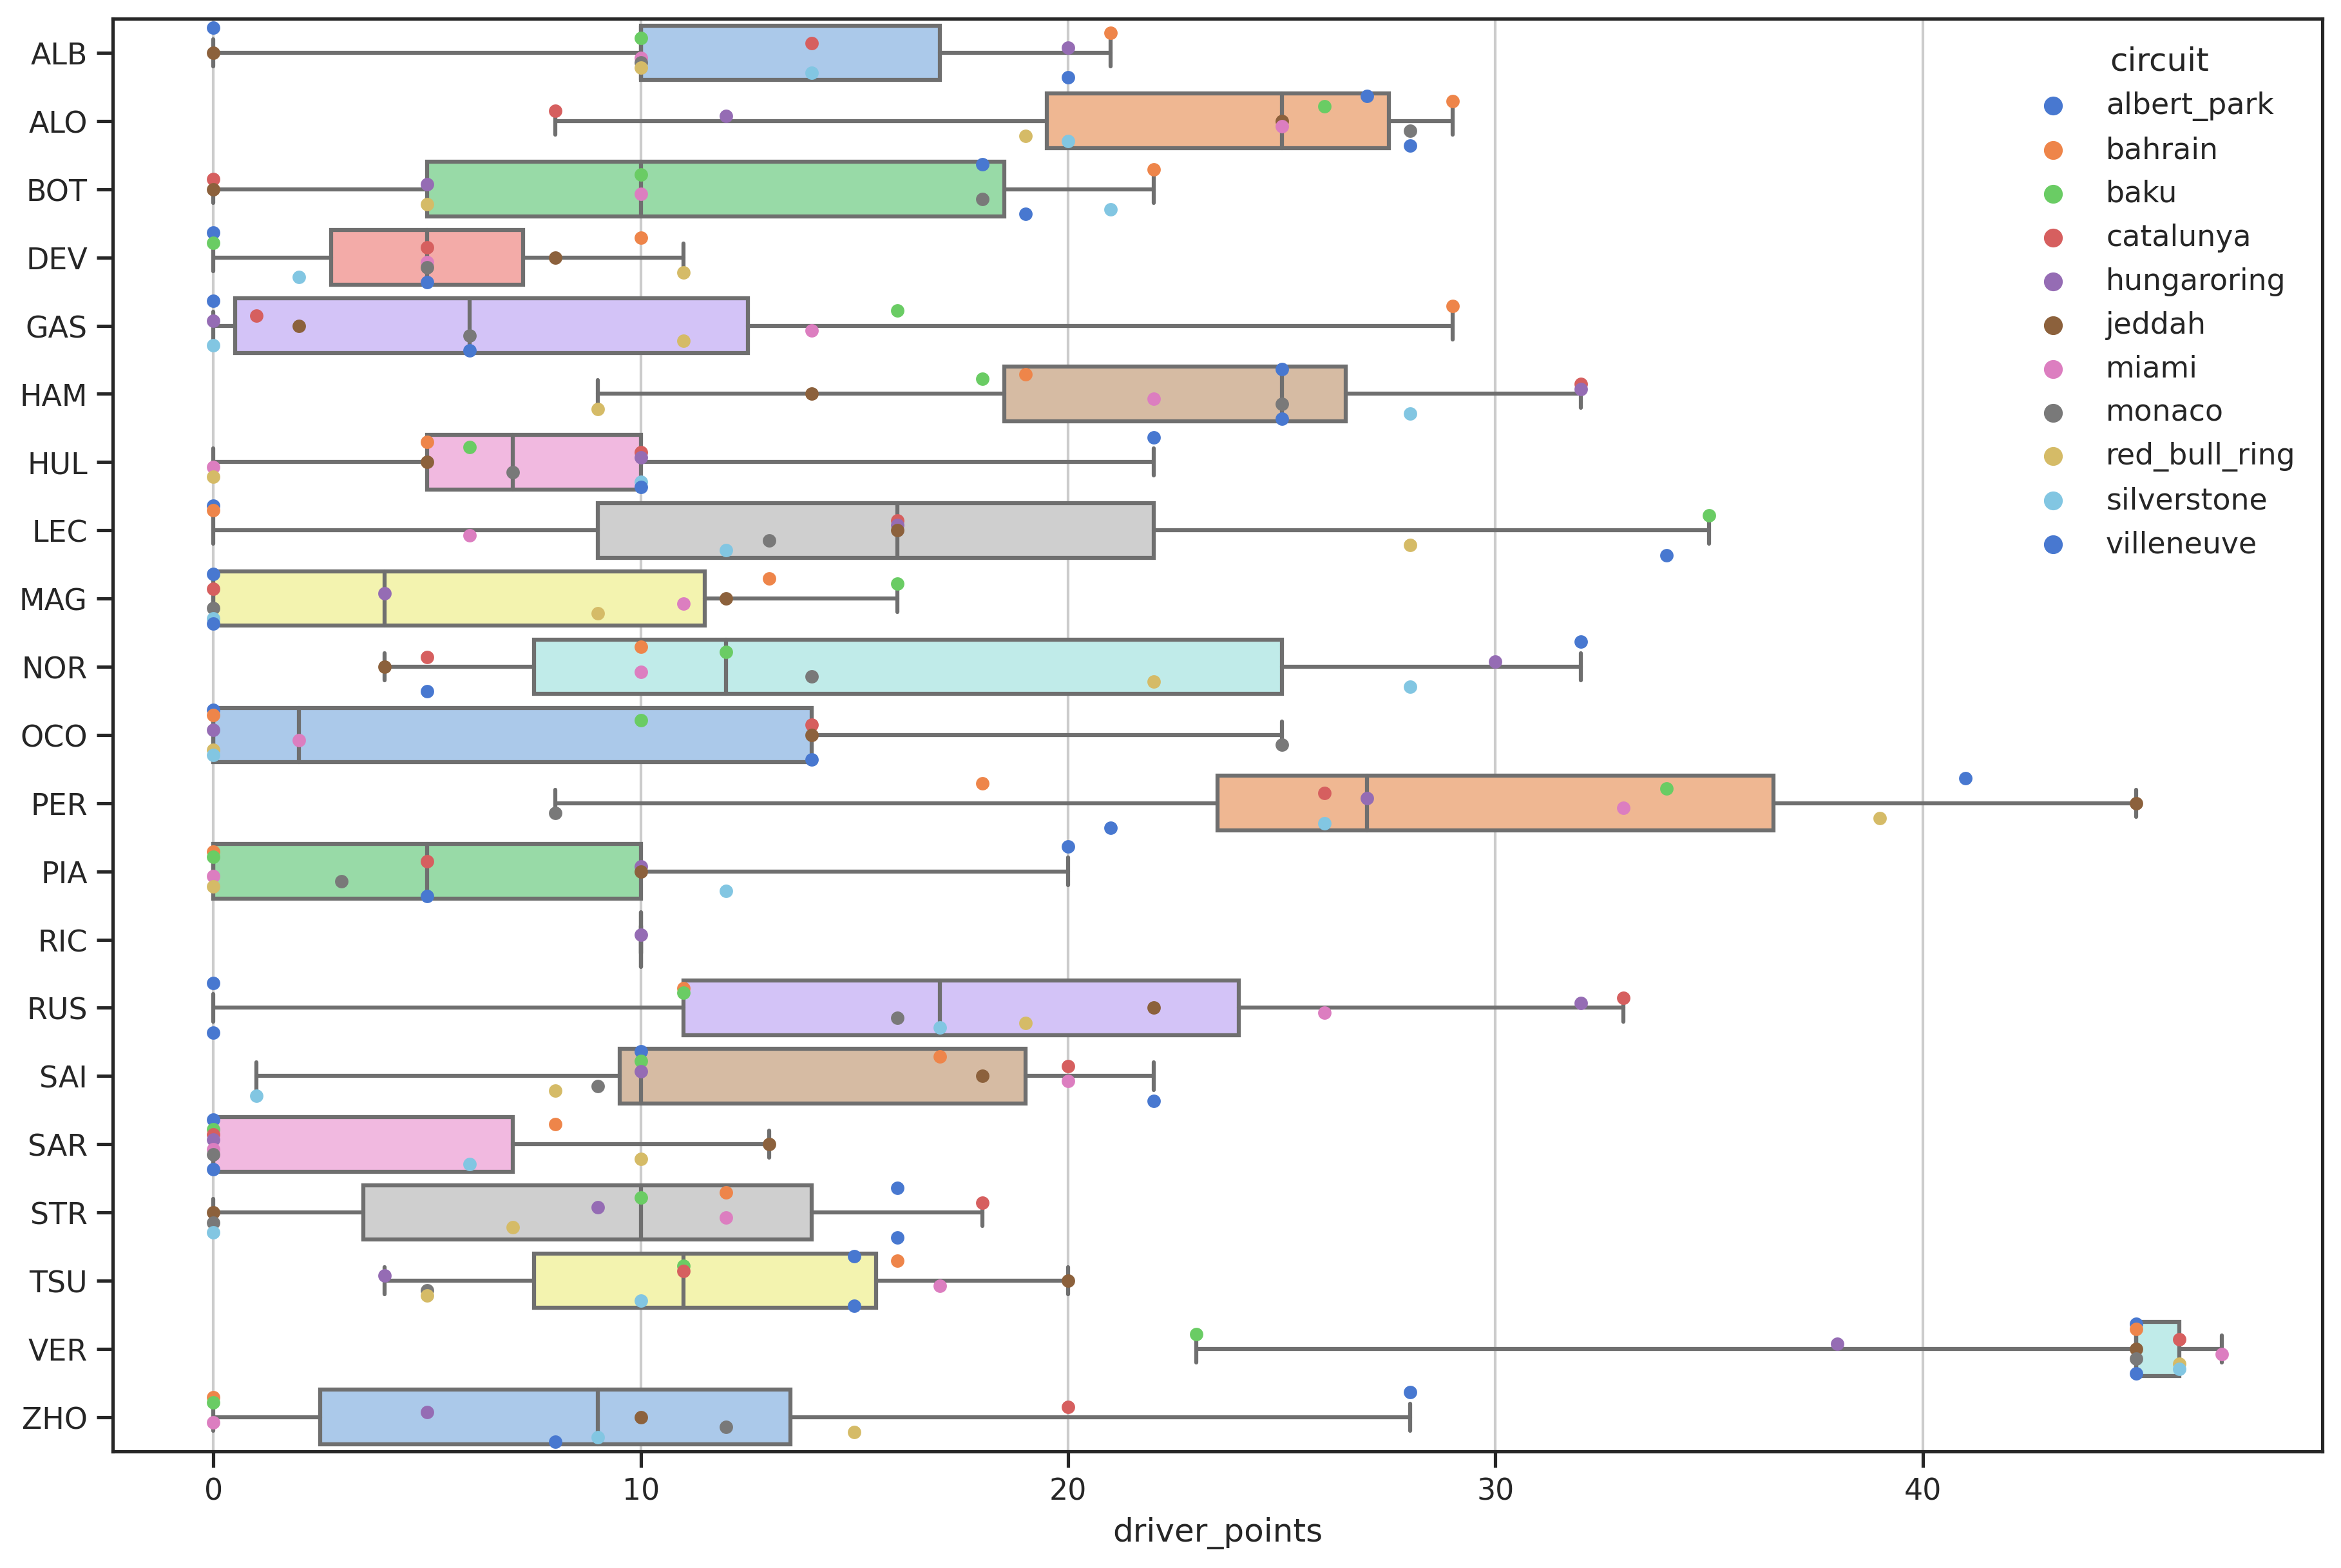

In [9]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    data=df.reset_index(),
    x="driver_points",
    y="driver",
    palette="pastel",
    whis=[0, 100],
)

sns.stripplot(
    x="driver_points",
    y="driver",
    data=df.reset_index(),
    hue="circuit",
    linewidth=0,
    size=5,
    dodge=True,
    palette="muted",
)

ax.xaxis.grid(True)
ax.set(ylabel="")

[Text(0, 0.5, '')]

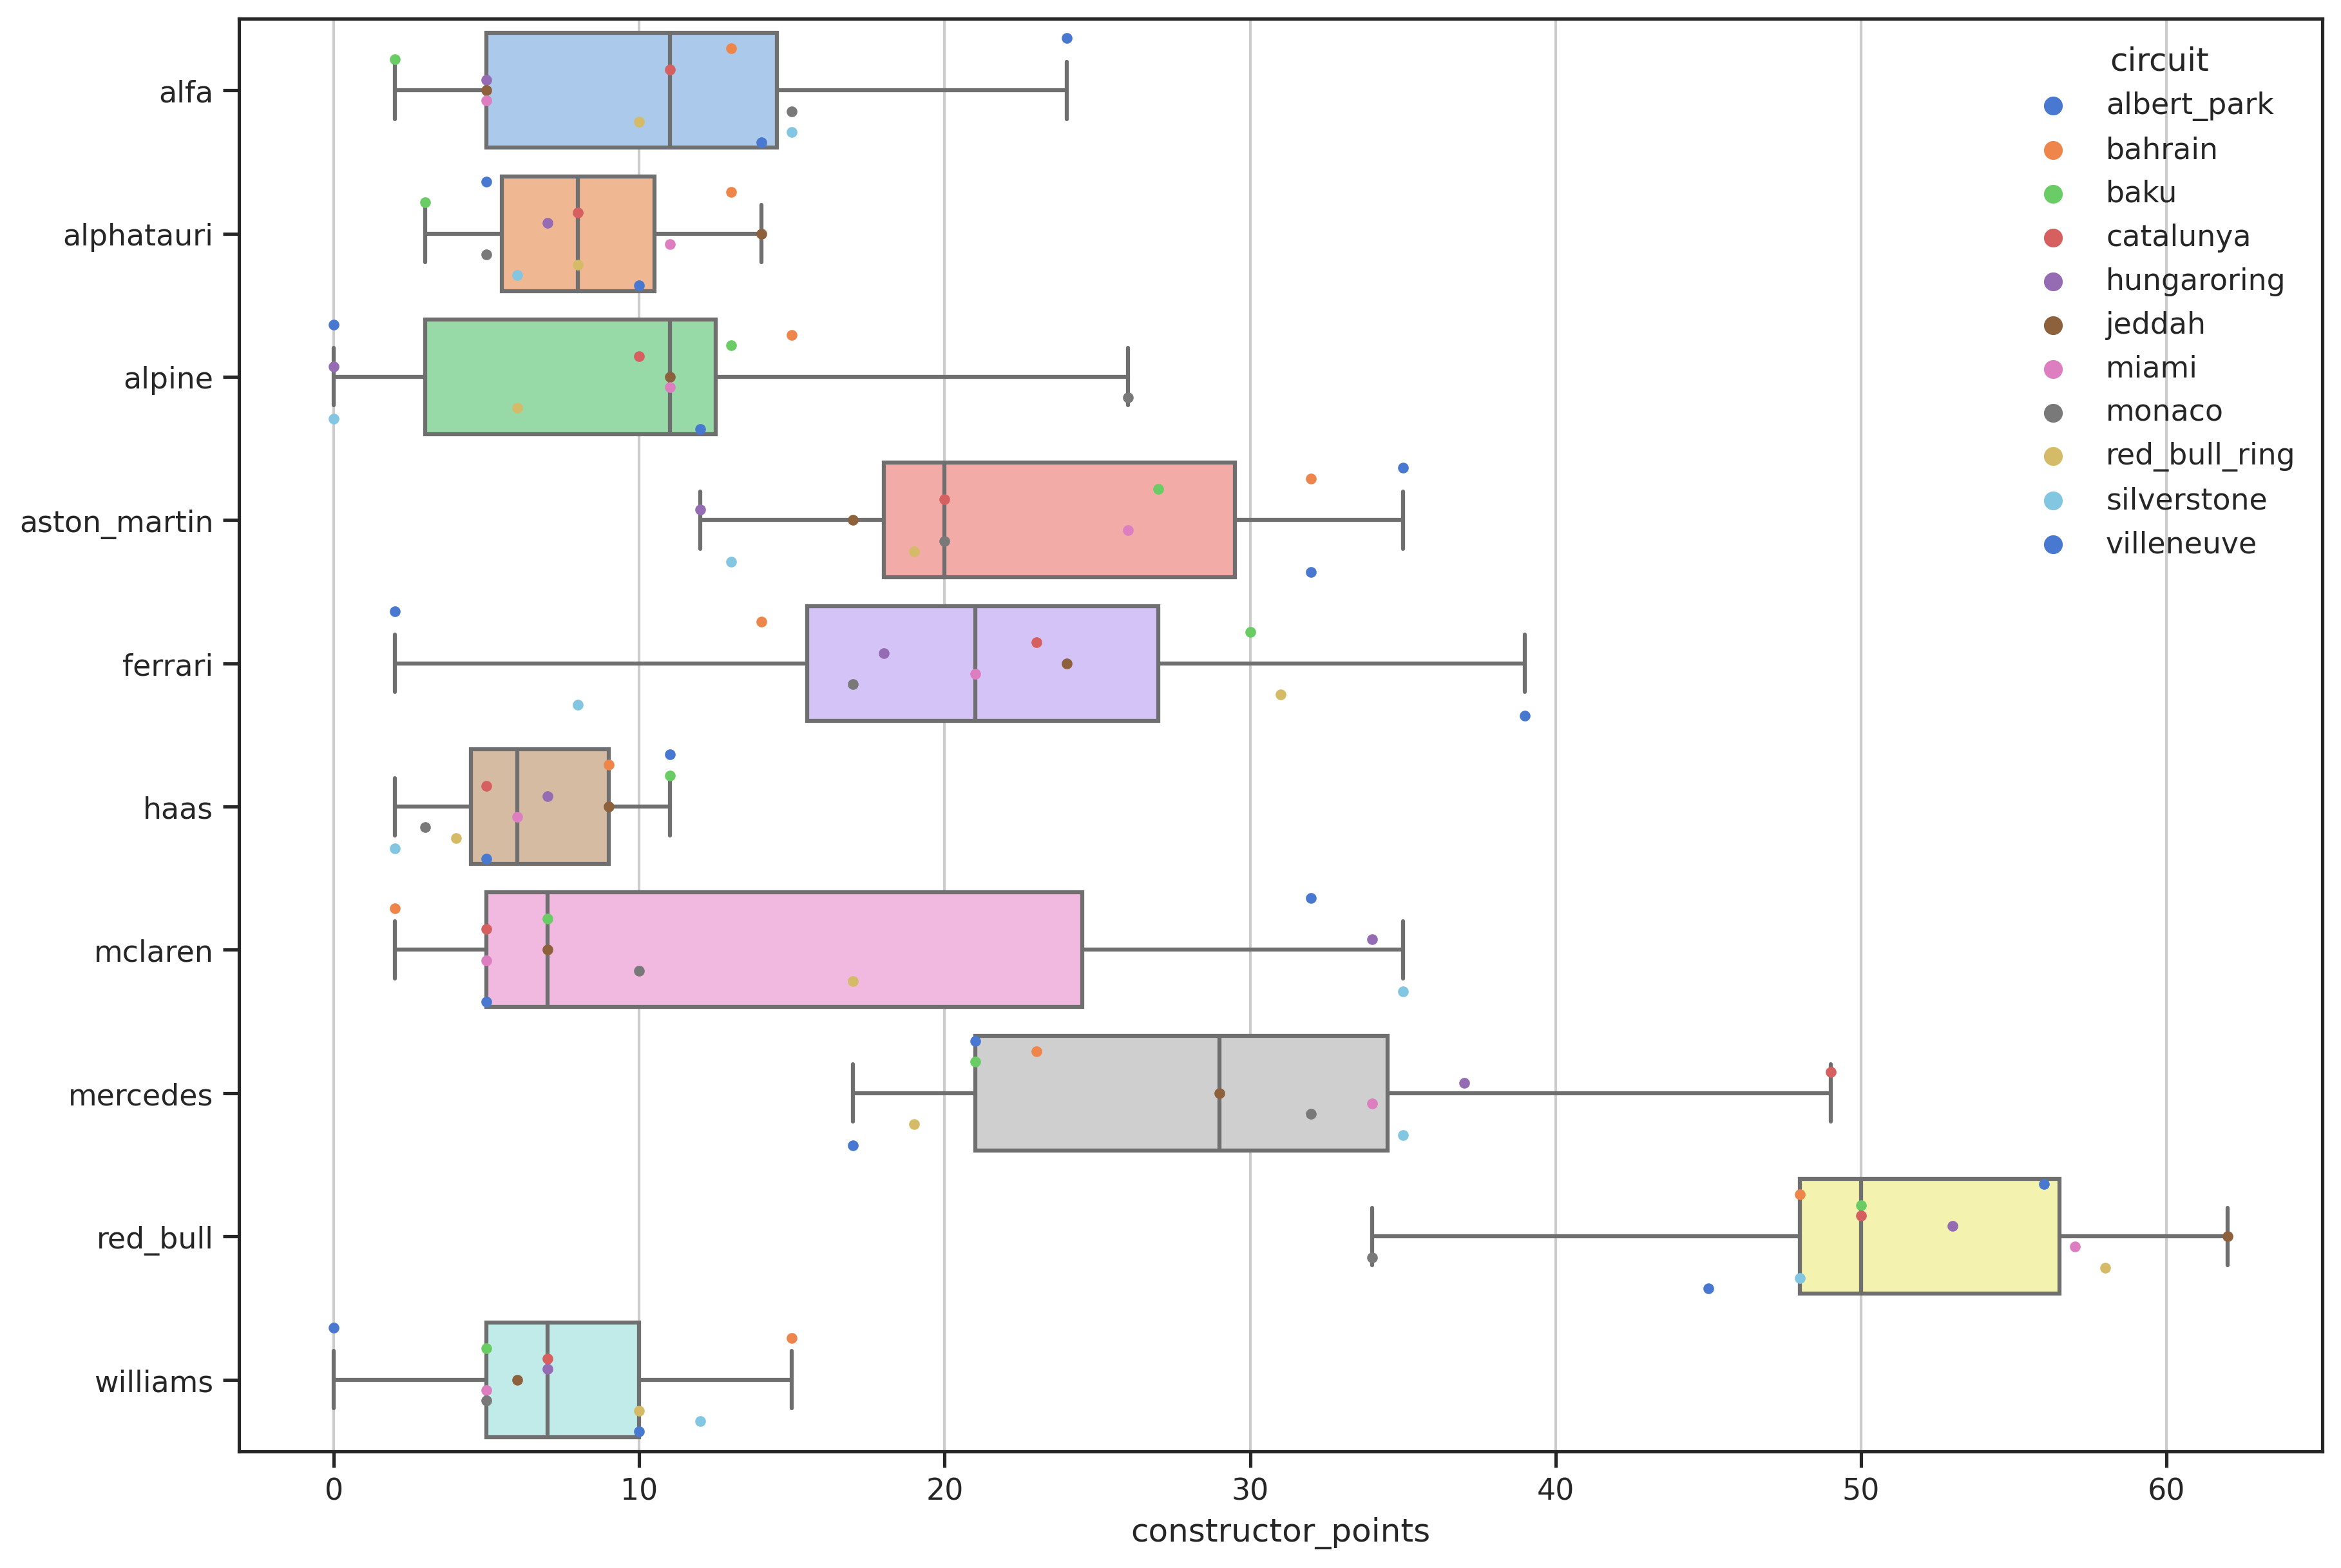

In [10]:
const_df = df.groupby(["circuit", "constructor"]).first()

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    data=const_df.reset_index(),
    x="constructor_points",
    y="constructor",
    palette="pastel",
    whis=[0, 100],
)

sns.stripplot(
    x="constructor_points",
    y="constructor",
    data=const_df.reset_index(),
    hue="circuit",
    palette="muted",
    linewidth=0,
    size=4,
    dodge=True,
)

ax.xaxis.grid(True)
ax.set(ylabel="")

<Axes: xlabel='driver_points', ylabel='Count'>

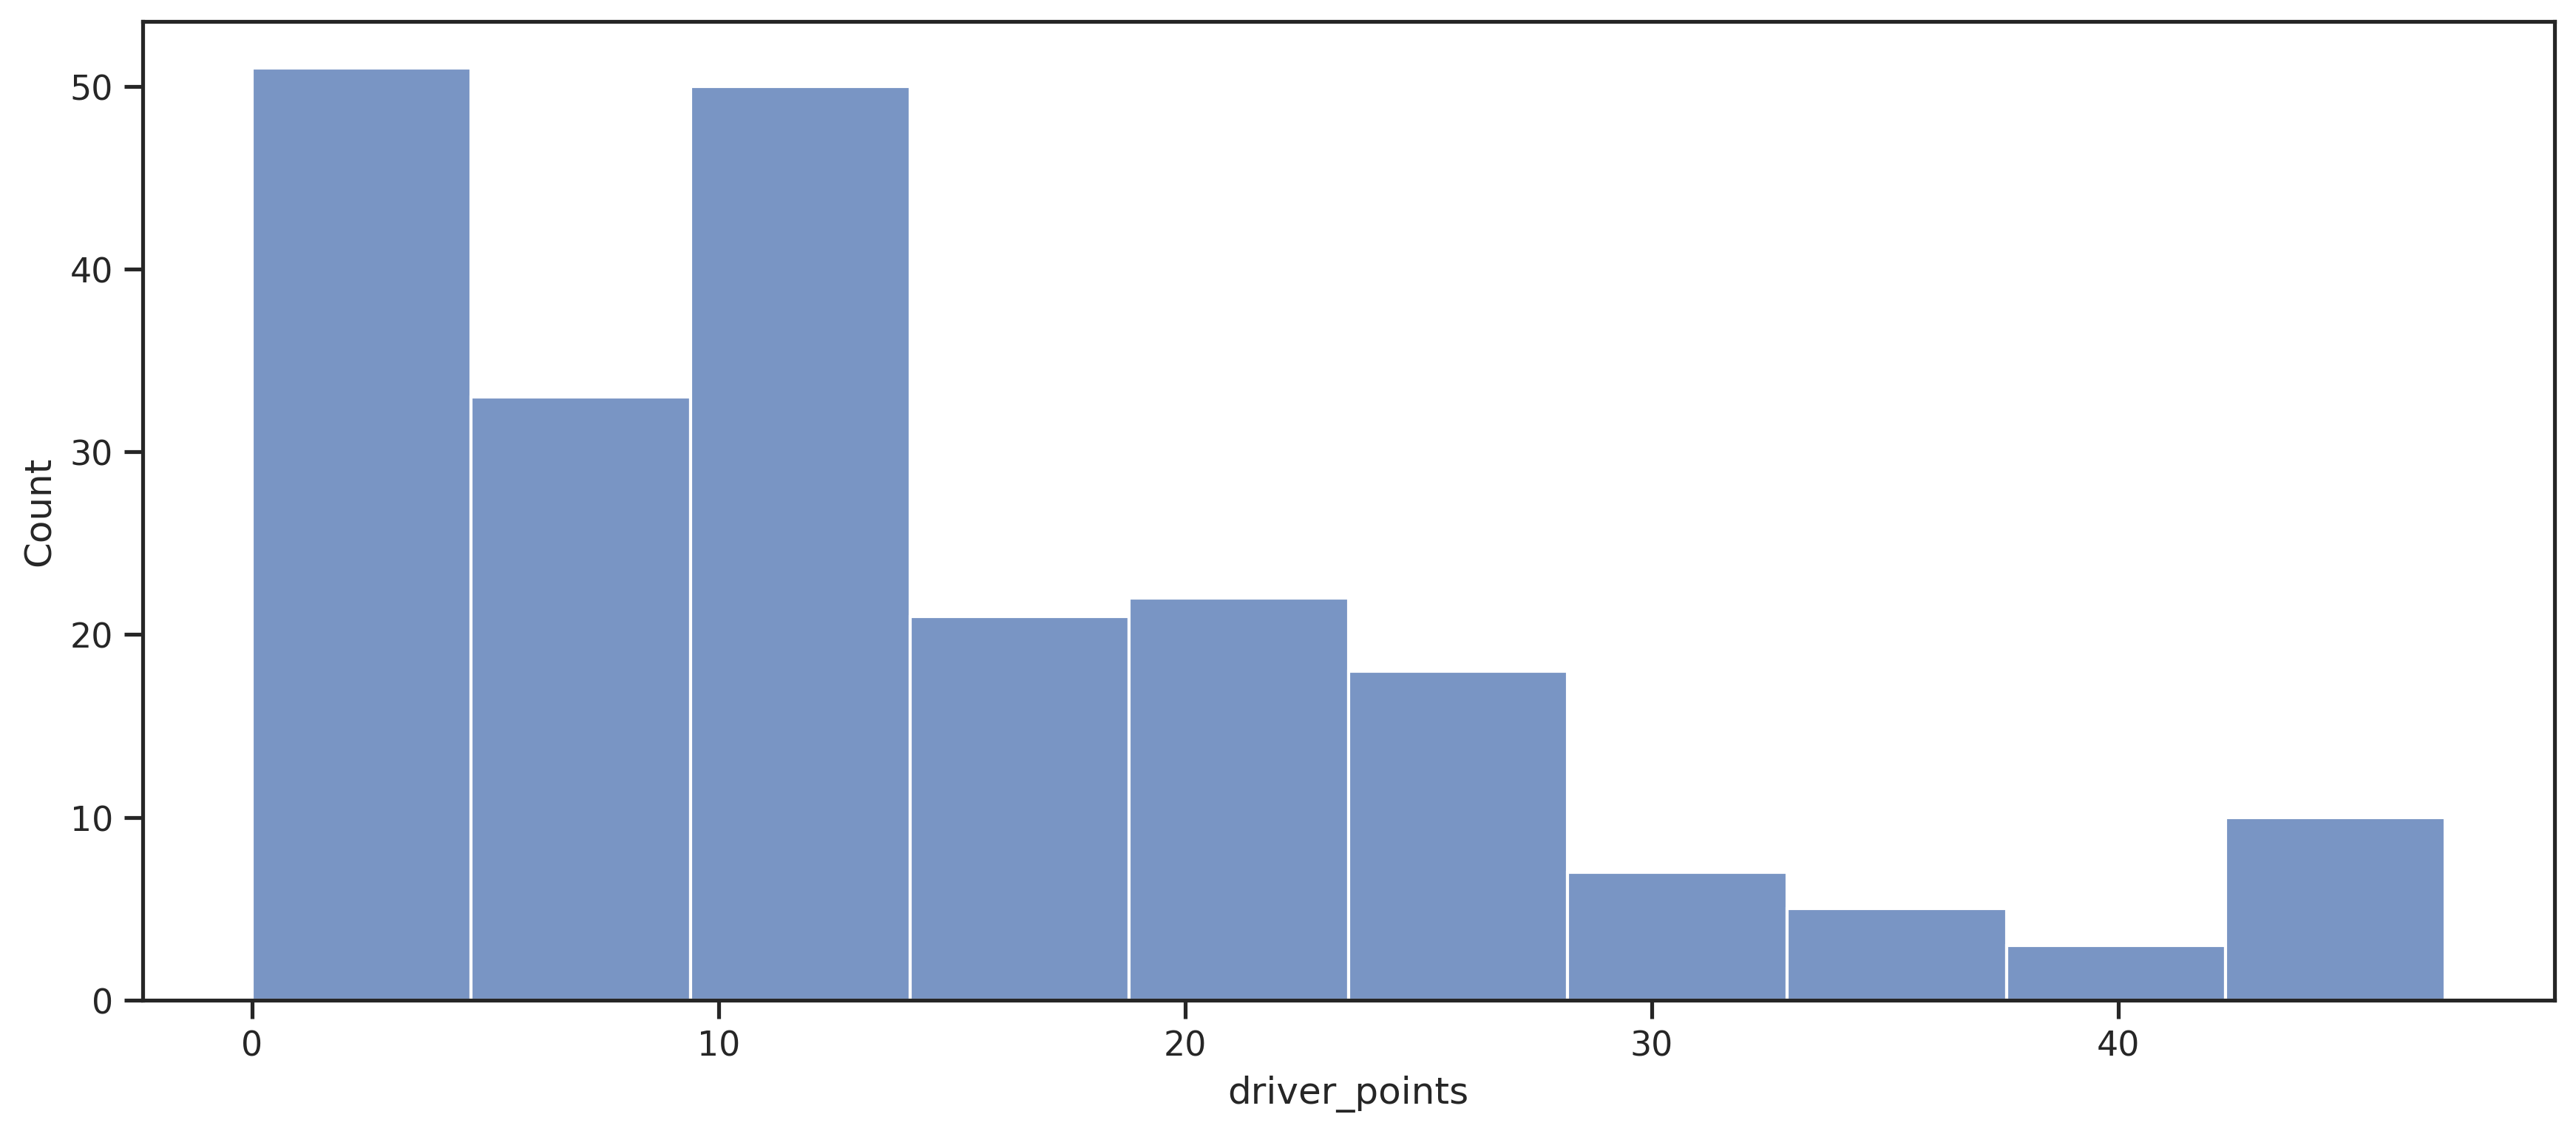

In [11]:
sns.histplot(df.reset_index(), x="driver_points")

In [12]:
df.reset_index()["driver_points"].var() / df.reset_index()["driver_points"].mean()

10.482506224940385

In [15]:
def make_comparison(idata, groups):
    groups_cat = groups.cat.categories
    idx = pd.Categorical(groups).codes

    columns = {}
    for idx_a, name_a in enumerate(groups_cat):
        for idx_b, name_b in enumerate(groups_cat):
            pp_a = idata.posterior_predictive["y"][:, :, idx == idx_a].values.flatten()
            pp_b = idata.posterior_predictive["y"][:, :, idx == idx_b].values.flatten()

            samples_a = np.random.choice(pp_a, size=1000)
            samples_b = np.random.choice(pp_b, size=1000)

            if idx_a != idx_b:
                prob_superior = (samples_a - samples_b).mean()
            else:
                prob_superior = 0

            columns.setdefault(name_a, []).append(prob_superior)

    comparison_df = pd.DataFrame.from_dict(columns).set_index(groups_cat)
    mask = np.triu(np.ones_like(comparison_df, dtype=bool))

    return comparison_df, mask

In [34]:
def negb_points(obs, groups):
    idx = pd.Categorical(groups).codes
    group_cats = pd.Categorical(groups).categories
    obs_data = obs.values

    with pm.Model(coords={"group": group_cats}) as negb_model:
        μ_α = pm.Gamma("μ_α", 5, 0.5)
        μ_β = pm.Uniform("μ_β", 0, 1)

        μ = pm.Gamma("μ", μ_α, μ_β, dims="group")
        α = pm.Exponential("α", 0.3, dims="group")

        y = pm.NegativeBinomial("y", alpha=α[idx], mu=μ[idx], observed=obs_data)

    return negb_model

def zi_negb_points(obs, groups):
    idx = pd.Categorical(groups).codes
    group_cats = pd.Categorical(groups).categories
    obs_data = obs.values

    with pm.Model(coords={"group": group_cats}) as negb_model:
        μ_α = pm.Gamma("μ_α", 5, 0.5)
        μ_β = pm.Uniform("μ_β", 0, 1)

        μ = pm.Gamma("μ", μ_α, μ_β, dims="group")
        α = pm.Exponential("α", 0.3, dims="group")
        ψ = pm.Uniform("ψ", 0, 1, dims="group")

        y = pm.ZeroInflatedNegativeBinomial("y", psi=ψ[idx], alpha=α[idx], mu=μ[idx], observed=obs_data)

    return negb_model

In [48]:
with zi_negb_points(
    df.reset_index()["driver_points"], df.reset_index()["driver"]
) as drivers_model:
    drivers_idata = pm.sample(target_accept=0.9, idata_kwargs={"log_likelihood": True})
    drivers_idata = pm.sample_posterior_predictive(
        drivers_idata, extend_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_α, μ_β, μ, α, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [y]


In [49]:
comparison_df, mask = make_comparison(drivers_idata, df.reset_index()["driver"])

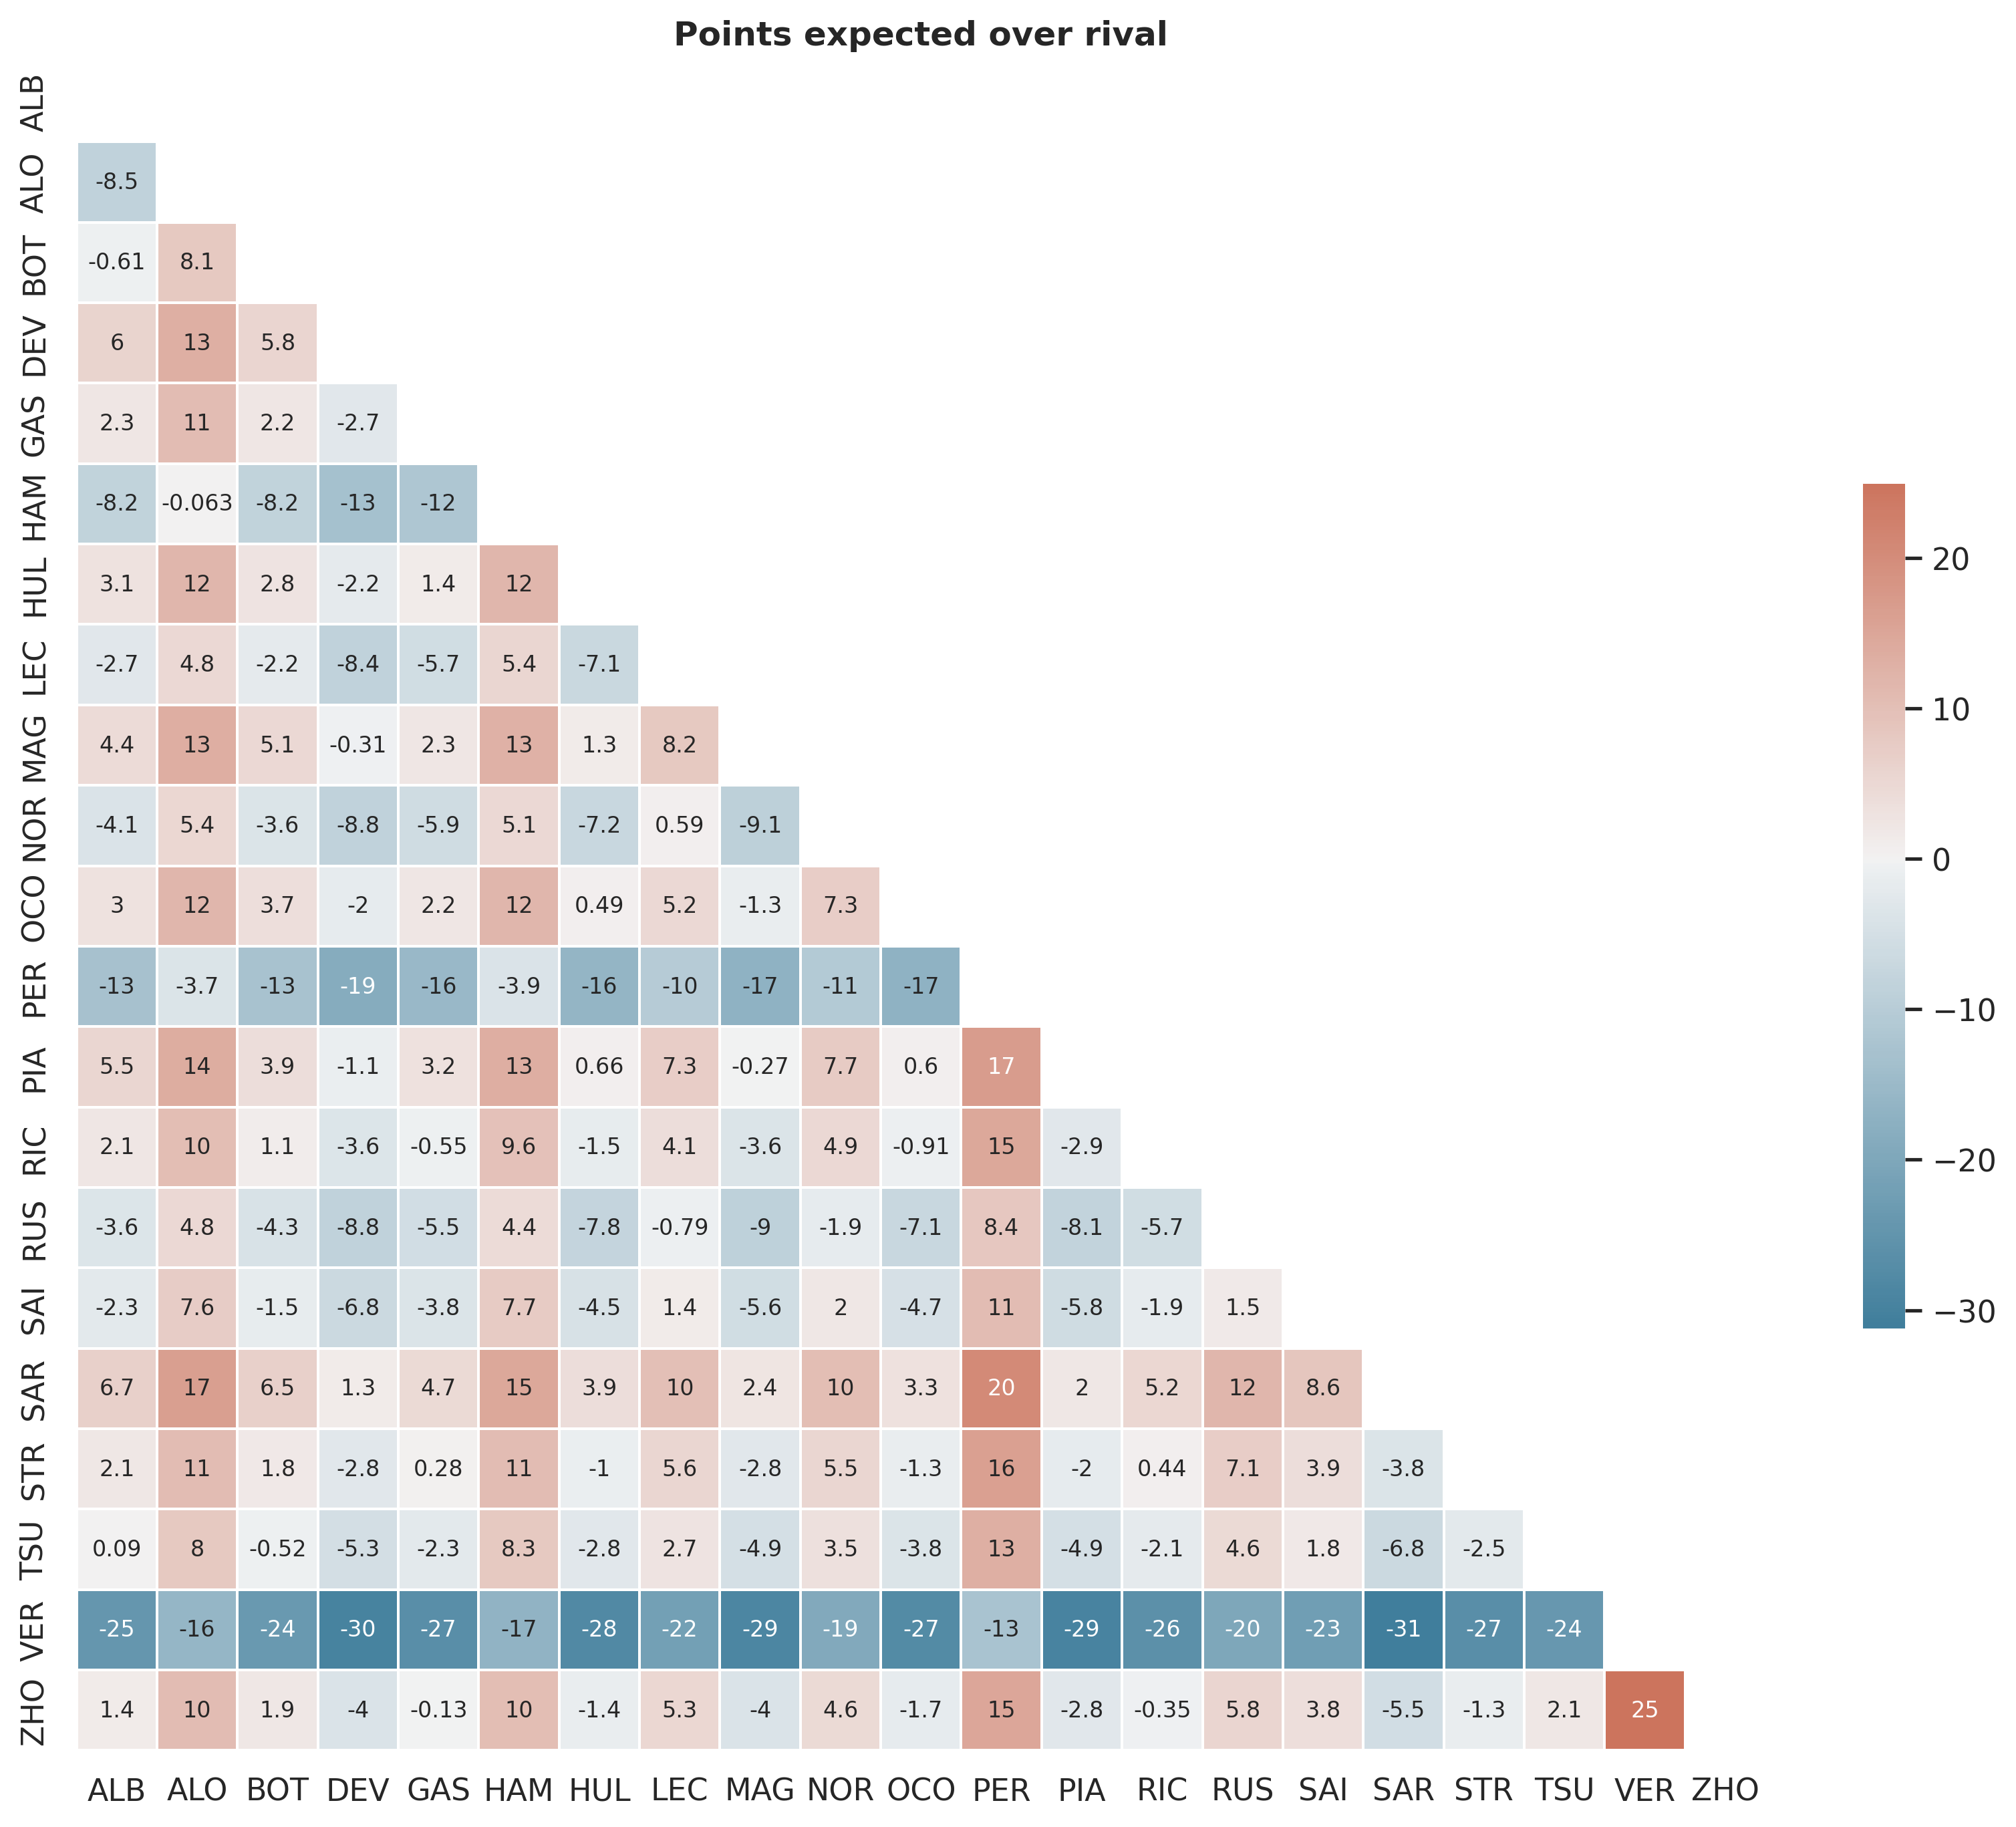

In [50]:
sns.set_theme(style="white")

cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax = sns.heatmap(
    comparison_df,
    cmap=cmap,
    mask=mask,
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"fontsize": 8},
).set(title="Points expected over rival")

# plt.savefig("negbinom-driver-comparison.png")

In [38]:
const_df = df.reset_index().groupby(["circuit", "constructor"]).first().reset_index()
const_df["constructor_points"].var() / const_df["constructor_points"].mean()

12.81196359869784

In [39]:
with zi_negb_points(
    const_df["constructor_points"], const_df["constructor"]
) as constructors_model:
    constructors_idata = pm.sample(
        target_accept=0.9, idata_kwargs={"log_likelihood": True}
    )
    constructors_idata = pm.sample_posterior_predictive(
        constructors_idata, extend_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_α, μ_β, μ, α, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [y]


In [40]:
comparison_df, mask = make_comparison(constructors_idata, const_df["constructor"])

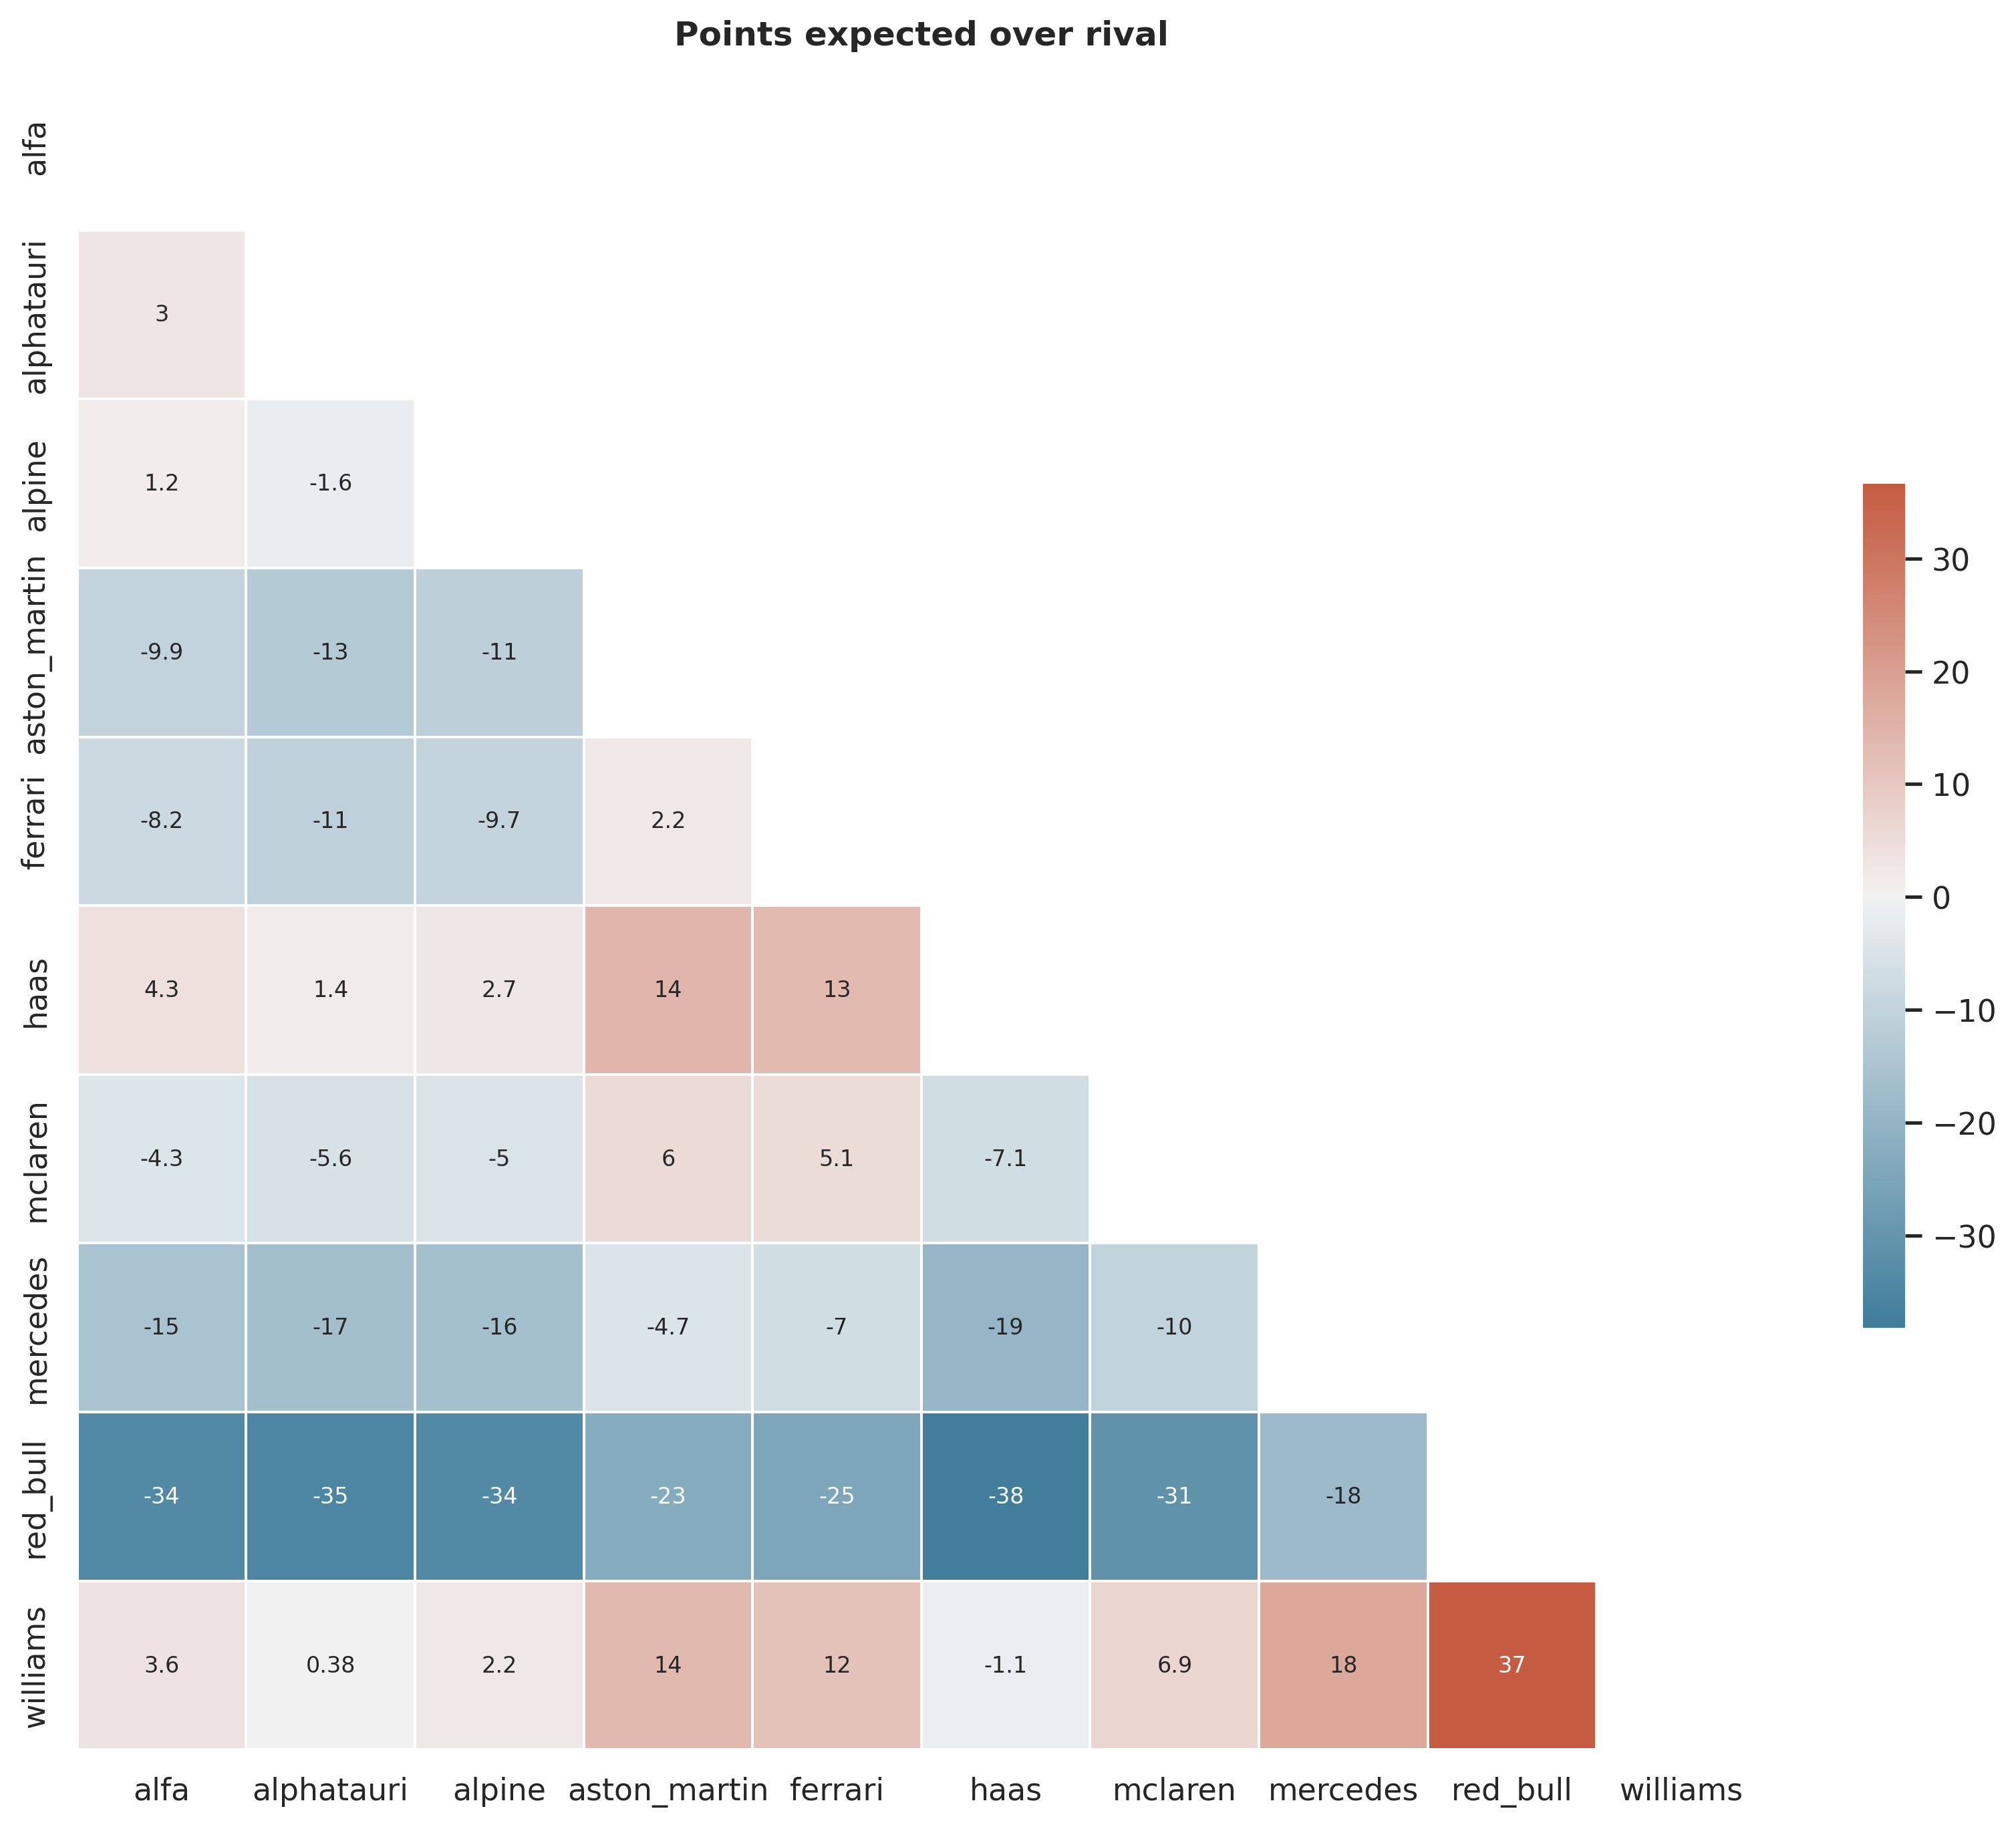

In [41]:
sns.set_theme(style="white")

cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax = sns.heatmap(
    comparison_df,
    cmap=cmap,
    mask=mask,
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"fontsize": 8},
).set(title="Points expected over rival")

# plt.savefig("negbinom-constructor-comparison.png")

In [44]:
old_df = df.loc[~df.index.isin(["hungaroring"], level=0)]
with zi_negb_points(
    old_df.reset_index()["driver_points"], old_df.reset_index()["driver"]
) as drivers_model:
    drivers_idata = pm.sample(target_accept=0.9, idata_kwargs={"log_likelihood": True})
    drivers_idata = pm.sample_posterior_predictive(
        drivers_idata, extend_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_α, μ_β, μ, α, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [y]


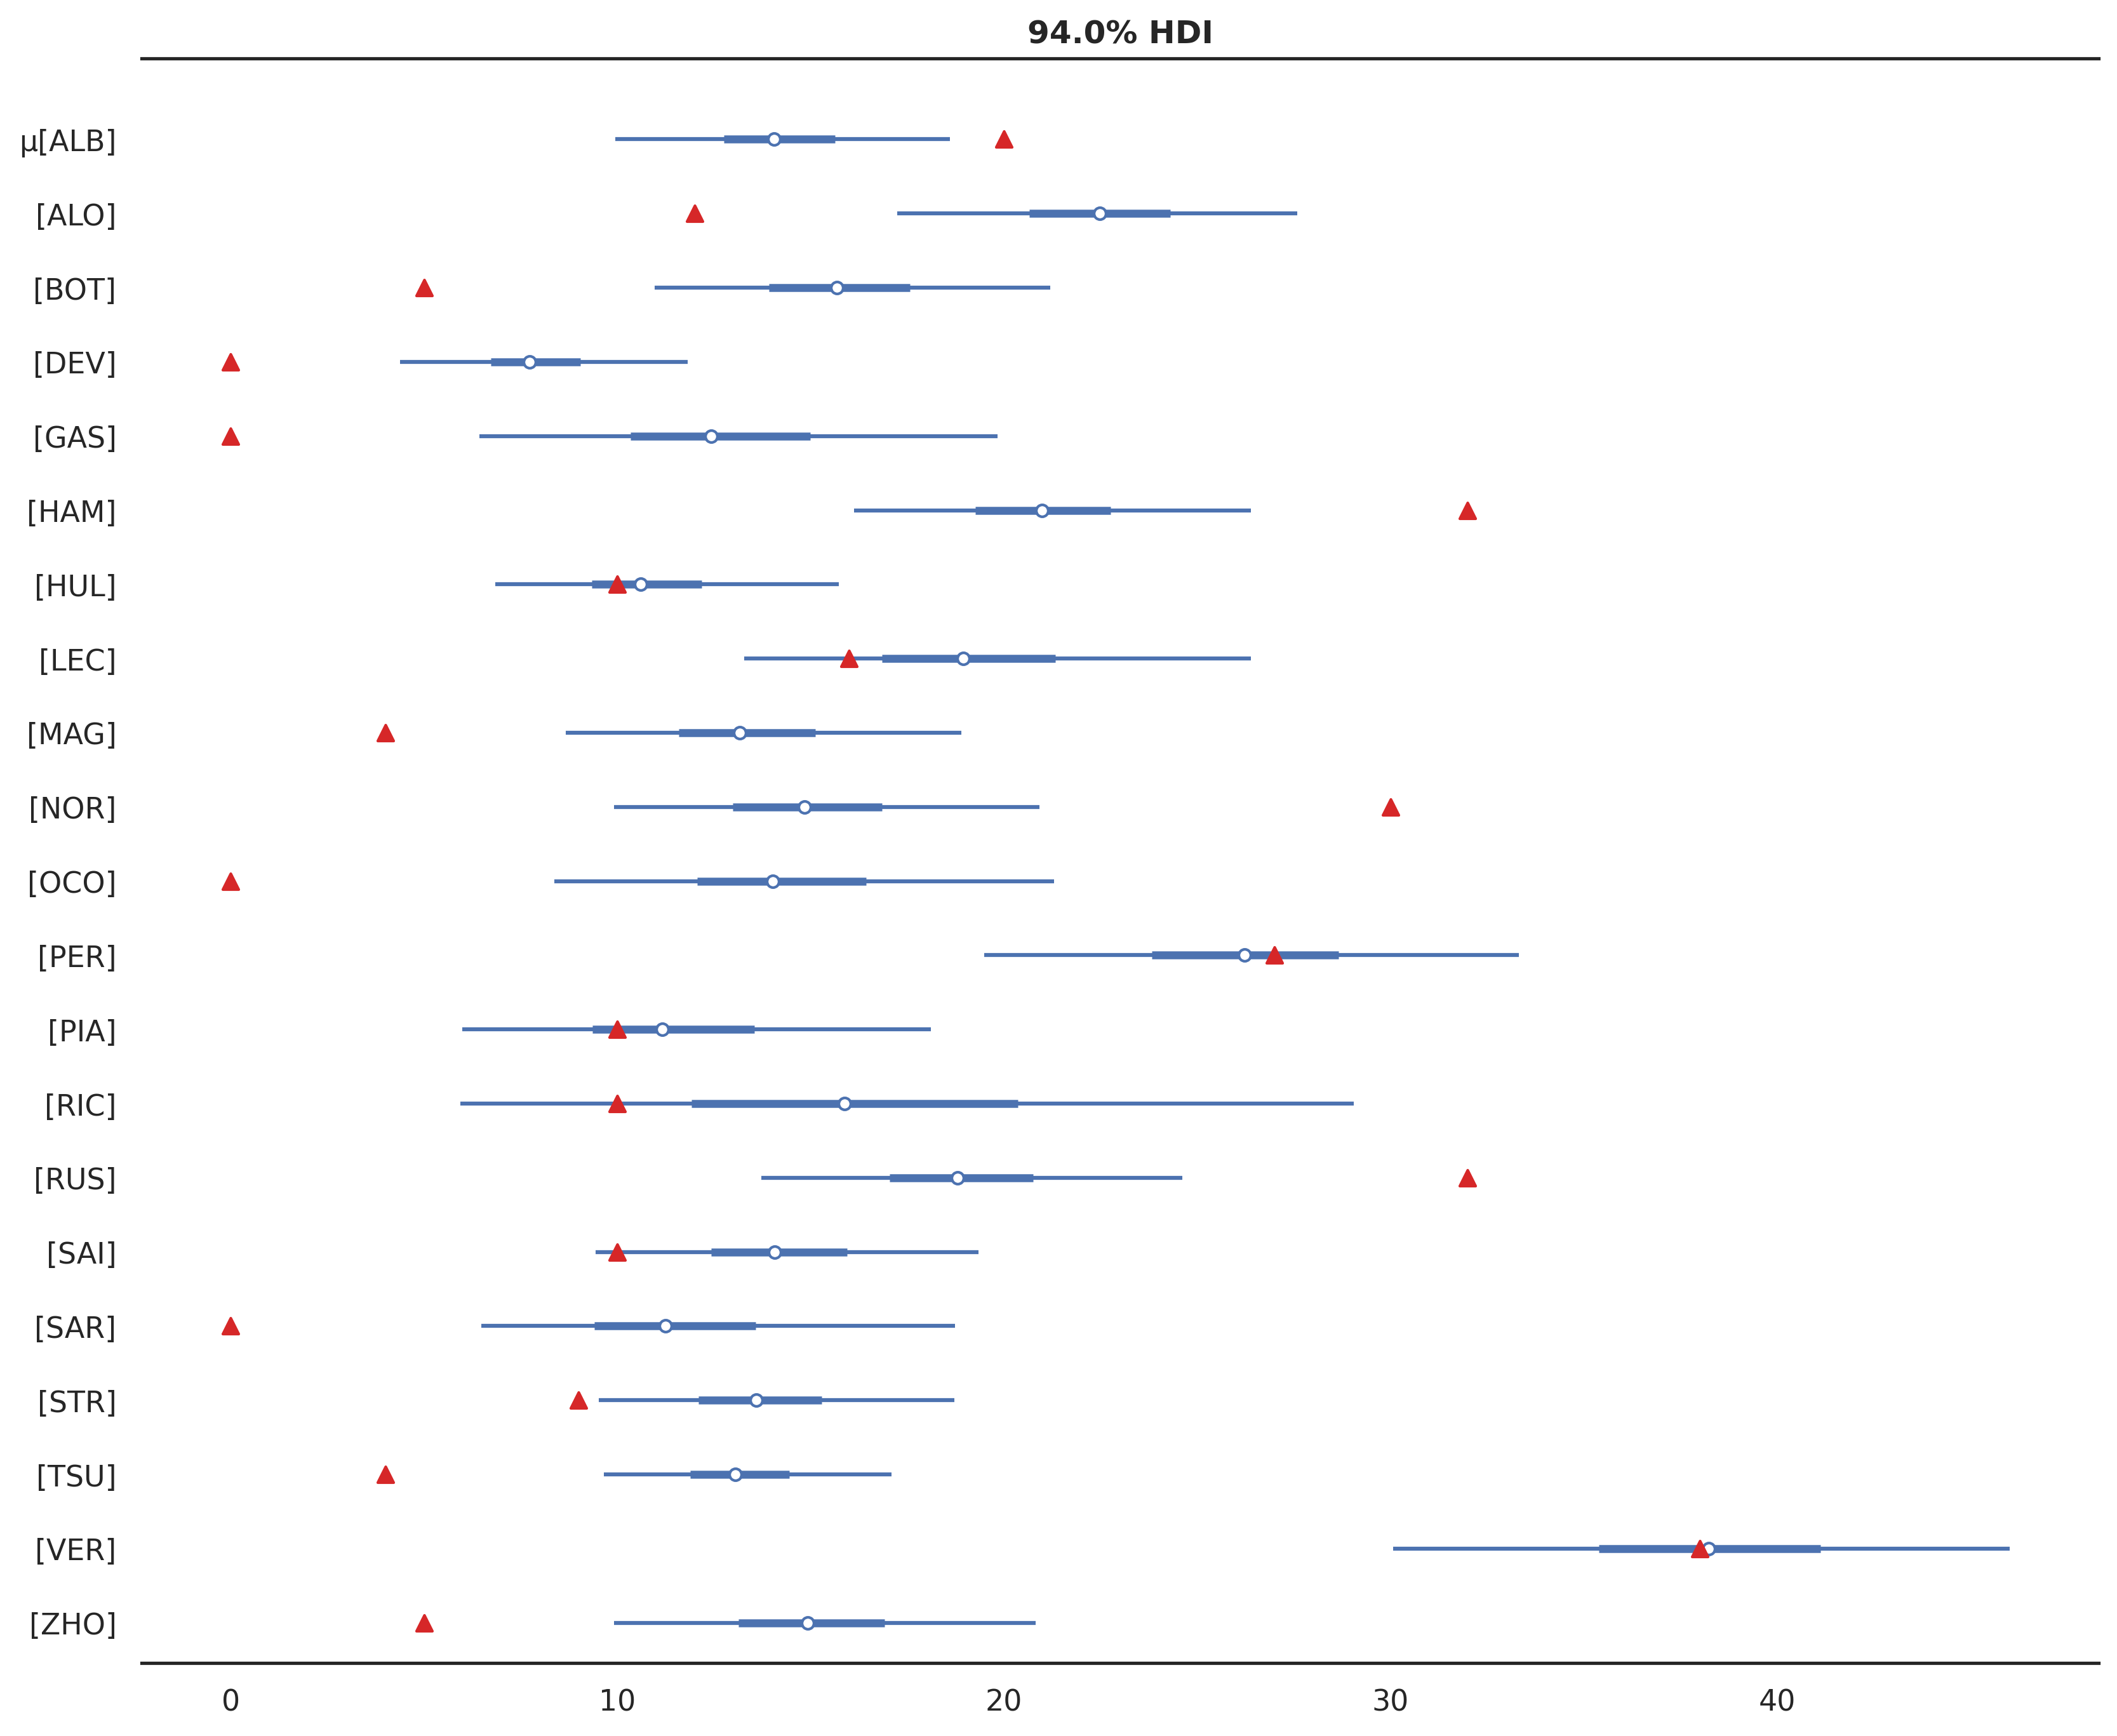

In [45]:
f, ax = plt.subplots(figsize=(11, 9))

axes = az.plot_forest(drivers_idata, var_names=["μ"], combined=True, ax=ax)
axis = axes[0]

ylocs = axis.yaxis.get_majorticklocs()[::-1]
xlocs = df.loc["hungaroring", :].sort_index()["driver_points"].values

axis.scatter(np.insert(xlocs, 3, 0), ylocs, color="tab:red", marker="^", zorder=100)

plt.savefig("hungaroring-pred-error.png")

In [46]:
old_df = const_df[~(const_df["circuit"] == "hungaroring")]
with zi_negb_points(
    old_df["constructor_points"], old_df["constructor"]
) as constructors_model:
    constructors_idata = pm.sample(
        target_accept=0.9, idata_kwargs={"log_likelihood": True}
    )
    constructors_idata = pm.sample_posterior_predictive(
        constructors_idata, extend_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_α, μ_β, μ, α, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [y]


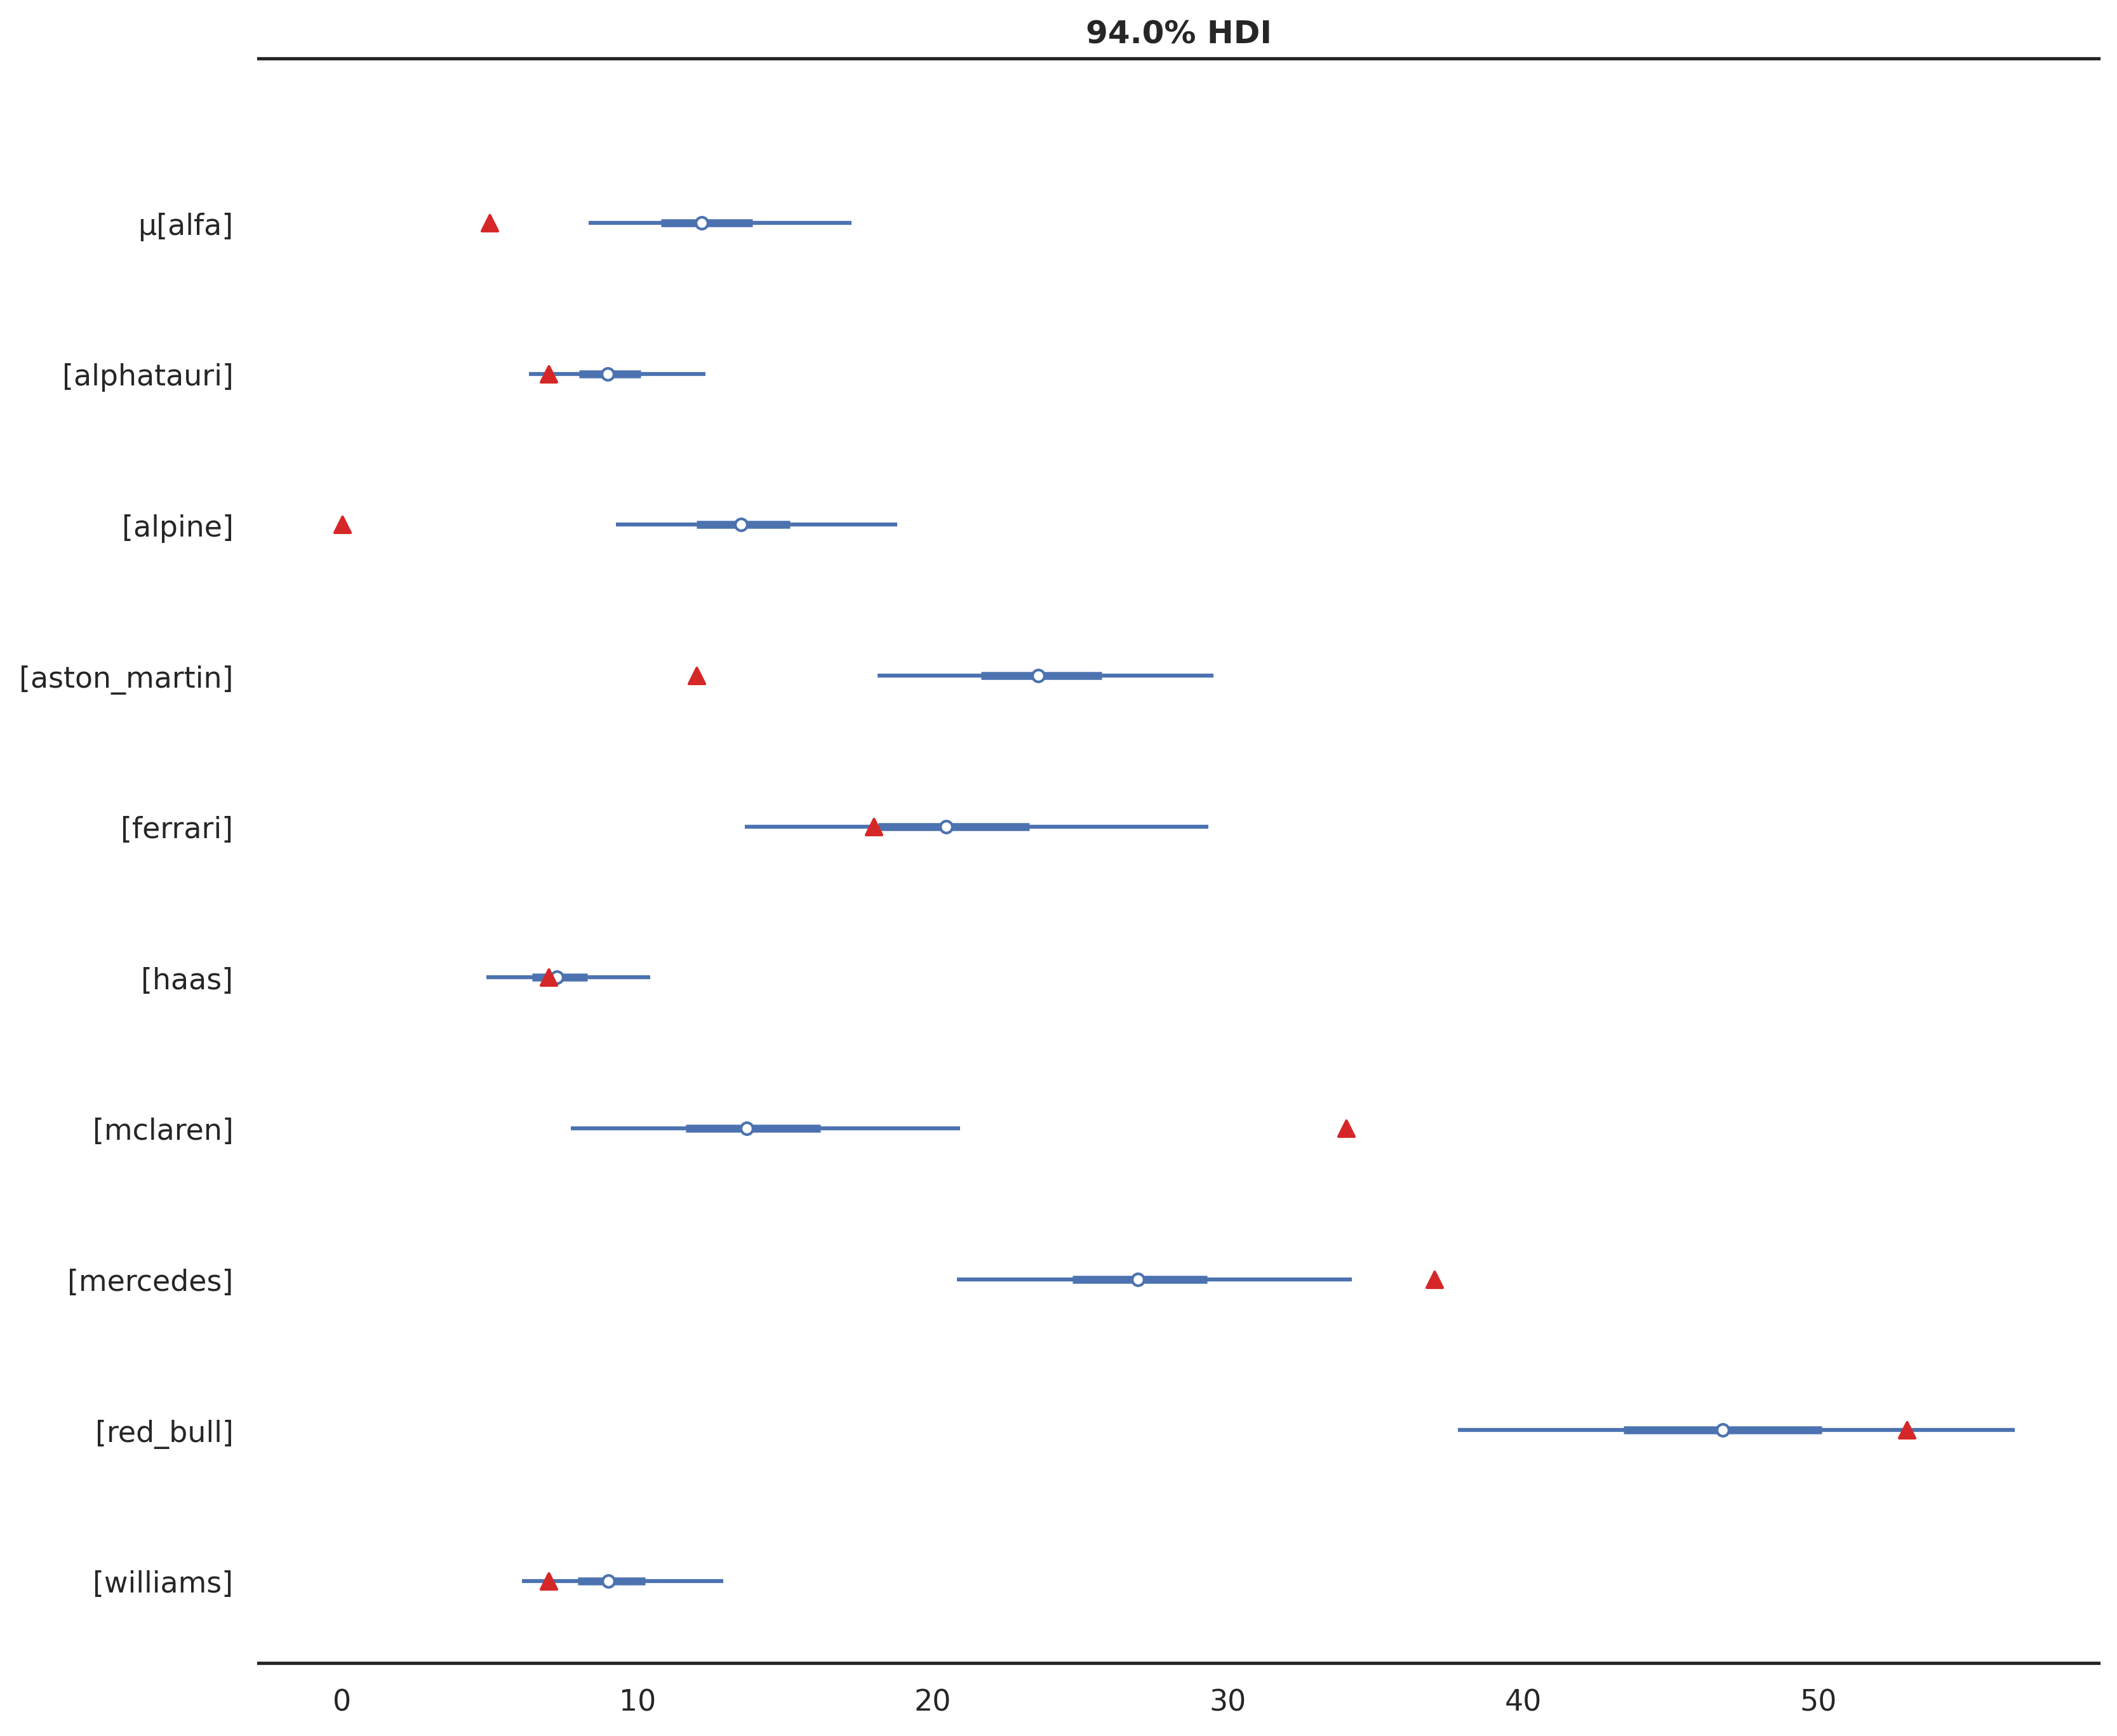

In [47]:
f, ax = plt.subplots(figsize=(11, 9))

axes = az.plot_forest(constructors_idata, var_names=["μ"], combined=True, ax=ax)
axis = axes[0]

ylocs = axis.yaxis.get_majorticklocs()[::-1]
xlocs = (
    const_df[const_df["circuit"] == "hungaroring"]
    .set_index("circuit")
    .sort_index()["constructor_points"]
    .values
)

axis.scatter(xlocs, ylocs, color="tab:red", marker="^", zorder=100)

plt.savefig("hungaroring-constructor-pred-error.png")

In [56]:
df.loc[df.index.isin(["ALB", "PIA", "ZHO", "SAR"], level=1)].sort_index()

round constructor  grid  position  points  fastest_lap  \
circuit       driver                                                           
albert_park   ALB         3    williams     8        19     0.0           19   
              PIA         3     mclaren    16         8     4.0           12   
              SAR         3    williams    18        16     0.0           13   
              ZHO         3        alfa    17         9     2.0           16   
bahrain       ALB         1    williams    15        10     1.0           15   
              PIA         1     mclaren    18        20     0.0           20   
              SAR         1    williams    16        12     0.0            4   
              ZHO         1        alfa    13        16     0.0            1   
baku          ALB         4    williams    12        12     0.0           15   
              PIA         4     mclaren    10        11     0.0           10   
              SAR         4    williams    14        16     0.0           17   
              ZHO         4        alfa    15        19     0.0           19   
catalunya     ALB         7    williams    18        16     0.0           19   
              PIA         7     mclaren     9        13     0.0           13   
              SAR         7    williams    20        20     0.0           20   
              ZHO         7        alfa    13         9     2.0           15   
hungaroring   ALB        11    williams    16        11     0.0           18   
              PIA        11     mclaren     4         5    10.0            8   
              SAR        11    williams    20        18     0.0           12   
              ZHO        11        alfa     5        16     0.0           15   
jeddah        ALB         2    williams    17        19     0.0           20   
              PIA         2     mclaren     8        15     0.0           16   
              SAR         2    williams    20        16     0.0           18   
              ZHO         2        alfa    11        13     0.0           13   
miami         ALB         5    williams    11        14     0.0           16   
              PIA         5     mclaren    19        19     0.0           18   
              SAR         5    williams    20        20     0.0           19   
              ZHO         5        alfa    14        16     0.0           14   
monaco        ALB         6    williams    13        14     0.0            8   
              PIA         6     mclaren    11        10     1.0           14   
              SAR         6    williams    16        18     0.0           13   
              ZHO         6        alfa    19        13     0.0           11   
red_bull_ring ALB         9    williams    10        11     0.0           11   
              PIA         9     mclaren    13        16     0.0           18   
              SAR         9    williams    18        13     0.0           12   
              ZHO         9        alfa    17        12     0.0           15   
silverstone   ALB        10    williams     8         8     4.0            8   
              PIA        10     mclaren     3         4    12.0            4   
              SAR        10    williams    14        11     0.0           13   
              ZHO        10        alfa    17        15     0.0           14   
villeneuve    ALB         8    williams     9         7     6.0           16   
              PIA         8     mclaren     8        11     0.0           11   
              SAR         8    williams    18        20     0.0           20   
              ZHO         8        alfa    20        16     0.0           17   

                           status  positions_gained  has_pole  \
circuit       driver                                            
albert_park   ALB        Accident                 0     False   
              PIA        Finished                 8     False   
              SAR       Collision                 2     False   
              ZH